In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from cardinality_estimation.featurizer import Featurizer
from query_representation.query import load_qrep

import glob
import random
import os
import json
import time

# Setup file paths / Download query data

In [2]:
import errno
def make_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [3]:
# TODO
TRAINDIR = os.path.join(os.path.join("", "queries"), "mlsys1-train")
VALDIR = os.path.join(os.path.join("", "queries"), "mlsys1-val")
TESTDIR = os.path.join(os.path.join("", "queries"), "mlsys1-test")

RESULTDIR = os.path.join("", "results")
make_dir(RESULTDIR)

# Query loading helper functions

In [4]:

def load_qdata(fns):
    qreps = []
    for qfn in fns:
        qrep = load_qrep(qfn)
        # TODO: can do checks like no queries with zero cardinalities etc.
        qreps.append(qrep)
        template_name = os.path.basename(os.path.dirname(qfn))
        qrep["name"] = os.path.basename(qfn)
        qrep["template_name"] = template_name
    return qreps

def get_query_fns(basedir, template_fraction=1.0):
    fns = []
    tmpnames = list(glob.glob(os.path.join(basedir, "*")))
    assert template_fraction <= 1.0
    
    for qi,qdir in enumerate(tmpnames):
        if os.path.isfile(qdir):
            continue
        template_name = os.path.basename(qdir)
        # let's first select all the qfns we are going to load
        qfns = list(glob.glob(os.path.join(qdir, "*.pkl")))
        qfns.sort()
        num_samples = max(int(len(qfns)*template_fraction), 1)
        random.seed(1234)
        qfns = random.sample(qfns, num_samples)
        fns += qfns
    return fns

# Evaluation helper functions

In [5]:
def get_preds(alg, qreps):
    if isinstance(qreps[0], str):
        # only file paths sent
        qreps = load_qdata(qreps)
    
    ests = alg.test(qreps)
    return ests

def eval_alg(alg, eval_funcs, qreps, samples_type, result_dir="./results/"):
    '''
    '''
    np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

    alg_name = alg.__str__()
    exp_name = alg.get_exp_name()
    
    if isinstance(qreps[0], str):
        # only file paths sent
        qreps = load_qdata(qreps)
    
    ests = alg.test(qreps)

    for efunc in eval_funcs:
        rdir = None
        if result_dir is not None:
            rdir = os.path.join(result_dir, exp_name)
            make_dir(rdir)

        errors = efunc.eval(qreps, ests, samples_type=samples_type,
                result_dir=rdir,
                num_processes = -1,
                alg_name = alg_name)

        print("{}, {}, #samples: {}, {}: mean: {}, median: {}, 99p: {}"\
                .format(samples_type, alg, len(errors),
                    efunc.__str__(),
                    np.round(np.mean(errors),3),
                    np.round(np.median(errors),3),
                    np.round(np.percentile(errors,99),3)))

# Load queries

In [6]:
# set template_fraction <= 1.0 to test quickly w/ smaller datasets
train_qfns = get_query_fns(TRAINDIR, template_fraction = 0.1)
val_qfns = get_query_fns(VALDIR, template_fraction = 1.0)
test_qfns = get_query_fns(TESTDIR, template_fraction = 1.0)
#trainqs = load_qdata(train_qfns)
## can take up a lot of memory, so we avoid loading query data if not needed.
#valqs = load_qdata(val_qfns)
#testqs = load_qdata(test_qfns)

print("Selected {} training queries, {} validation queries, {} test queries".\
      format(len(train_qfns), len(val_qfns), len(test_qfns)))

Selected 119 training queries, 621 validation queries, 1260 test queries


# What is cardinality estimation and query optimization?

We are going to use a simple / small query for visualizing / illustrating the key properties of our tasks. These visualization functions work for larger queries, but we'll need to play around with matplotlib to make them look fine; it gets too large to visualize properly for most CEB queries.

### Simple example query

* Queries in CEB are stored in *.pkl file because it contains more than just the SQL; Among other things, each query contains cardinality (size) estimates for all <it> subplans </it> of the query. These subplans are the intermediate results encountered by an optimizer when joining and optimizing the query (shown later).
* The loaded file is a dictionary; Next we access the SQL:

In [7]:
qfn = os.path.join(os.path.join("queries", "example_queries"), "2.pkl")
qrep = load_qdata([qfn])[0]
print(qrep["name"])
print(qrep["sql"])

2.pkl
SELECT COUNT(*)
FROM title as t,
kind_type as kt,
cast_info as ci,
role_type as rt,
name as n
WHERE
t.id = ci.movie_id
AND t.kind_id = kt.id
AND ci.person_id = n.id
AND ci.role_id = rt.id
AND kt.kind IN ('movie')
AND rt.role IN ('actor', 'director')
AND n.gender IN ('f')
AND t.production_year <= 2015



### Join Graph, Cardinality Estimation and Query Optimization

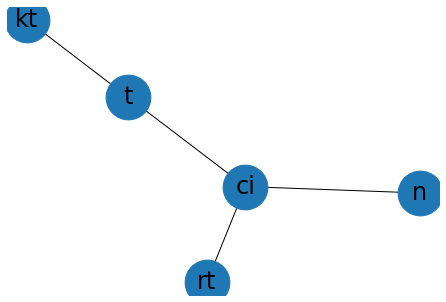

In [8]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from query_representation.viz import draw_plan_graph
#matplotlib.use('Agg') # no UI backendz

join_graph = qrep["join_graph"]
nx.draw(join_graph, pos=nx.spring_layout(join_graph), 
        with_labels=True, node_size=2000, font_size=24)
plt.show()

* The two key properties of a query we care about are the join graph, and each of its subplans --- which is any connected subgraph of the join graph.

* Note: each node in the join graph represents a table used in the SQL query above (the node label is the ALIAS used in the SQL, such as title as t); An edge in the join graph implies there is a condition such as t.id = ci.movie_id in the query above.

* The process of optimizing a query is essentially like contracting the join graph to a point of single node; at each step, you are allowed to combine (``join``) any two connected nodes. Any order of applying the joins is semantically an equivalent way to execute a SQL query. The job of an optimizer is to choose a fast way to execute the queries. More [details](https://bertwagner.com/posts/does-the-join-order-of-my-tables-matter/)

* The join graph does not show the query' filters / predicates. For instance, `rt.role IN ('actor', 'director')` in the SQL query above. IN CEB, we will have a few different join graphs, and then for each join graph, A LOT of queries in which we vary these filters --- which changes the sizes of each node in the join graph; These filters can also interact with each other after joins --- and how these sizes change is crucial for choosing between different orders of executing the joins.

* Cardinality estimation is about estimating sizes for all the subplans (i.e., connected subgraphs of the join graph). These subgraphs would be encountered by an optimizer when it considers a particular sequence of joins. Processing a large sized join can be expensive --- because that will involve more CPU, more memory usage, and so on; 

* Some join orders can be particularly bad. For instance, consider joining the tables `cast_info (ci)` and `title (t)` first in the query above. These are both very large tables; Joining them, creates an even larger intermediate results. Future join operations will have to process these intermediate rows. Instead, if you join `cast_info` with `role_type`, then as the filter predicate: `rt.role IN ('actor', 'director')` reduces the size of the `cast_info` table in a non-trivial way. And so on. 

* Note: If the filter on title (t.production_year <= 2015) was different, such as `t.production_year <= 1890`, which will mean there would be very few qualifying rows in the `title` table, then joining the `cast_info` and `title` tables in the first step may have been a good move!

### Subset Graph / Plan Graph

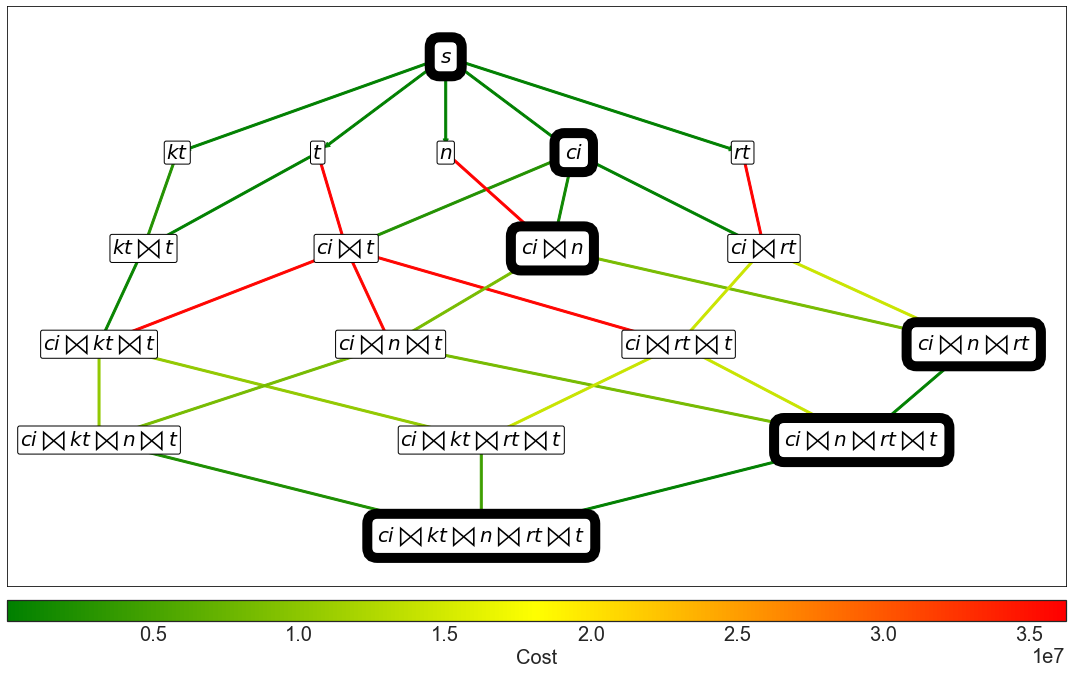

In [9]:
# copying, because we will do changes to it for visualizing, such as adding a source node.
from cardinality_estimation.algs import TrueCardinalities
import copy

subsetg = copy.deepcopy(qrep["subset_graph"])
subsetg = subsetg.reverse()

nodes = list(subsetg.nodes())
nodes.sort(key=lambda x: len(x))
final_node = nodes[-1]

true_alg = TrueCardinalities()
y = true_alg.test([qrep])[0]

fig, ax = plt.subplots(1,1,figsize=(15,10))
SOURCE_NODE = tuple(["s",])

draw_plan_graph(subsetg, y, "C", ax=ax, source_node=SOURCE_NODE,
               final_node=final_node, font_size=20, width=.0, edge_color=None, 
               bold_opt_path=True)

* It is useful to represent all these subplans in a graph structure of its own. This lets us reason about query optimization in terms of standard graph theoretic constructs. In code, we refer to this as the subset_graph; Intuitively, it should be clear what each node and edges of this graph represent.

* Please see Section 4 of this [paper](https://vldb.org/pvldb/vol14/p2019-negi.pdf) for precise mathematical definitions of what we show here --- including how edges are defined etc. , and note that we referred to it as the plan graph in the paper. Another recent [interesting paper](https://arxiv.org/abs/2105.08878) referred to the same structure as cardinality estimation graphs.

* Each edge in this subset graph is a join in the query. An optimizer typically costs each join using various heuristics. We use a simple, but practically reasonable, cost model (referred to as `C` in the [paper](https://vldb.org/pvldb/vol14/p2019-negi.pdf)) --- these are shown in green-yellow-red colors going from cheaper to expensive operations (note: the costs are a function of cardinalities; we use true cardinalities to cost these edges). Each path from the top `S` node, to the bottom-most node represents a [left deep plan]
(https://www.mathcs.emory.edu/~cheung/Courses/554/Syllabus/5-query-opt/left-deep-trees.html) in the context of query optimization. Thus, the shortest path from the top node (S) to the bottom node (D) is equivalent to an optimizer finding the cheapest (left deep) plan (typically, using dynamic programming algorithms). The shortest path given the true cardinalities is highlighted.

### The task

* The task is to give a size estimate to each node in the subset graph shown above. Each node corresponds to a particular subgraph of the join graph, i.e., a particular sequence of joins. Thus, there is a corresponding SQL query, and a true label for this query (which we have generated by executing these queries). 

* The learning task is to take a representation of the SQL query associated with each node (featurizes the tables, joins, and filters in the query), and output a size estimate for it.

* For instance, we will show how we evaluate two baselines below --- the actual true cardinalities, and the estimates from PostgreSQL.

In [10]:
from cardinality_estimation.algs import TrueCardinalities, Postgres
true_alg = TrueCardinalities()
pg_alg = Postgres()
y = true_alg.test([qrep])[0]
ypg = pg_alg.test([qrep])[0]

### Evaluation 1: Q-Error

* Q-Error = `max((y/yhat), (yhat/y))`
* This was defined by Moerkotte et al. in the [paper](http://www.vldb.org/pvldb/vol2/vldb09-657.pdf). It provides strong arguments for why this is the right way to evaluate cardinality estimates if we care about query plans (as opposed to error metrics like mean squared error). 

### Evaluation 2: Plan-Cost

* Here, we will take the estimates provided, cost each edge in the subset graph based on those estimates, and find the best plan based on these estimated costs. 

* As we see below, the plan chosen using PostgreSQL estimates was different from the plan chosen using true estimates. 

* The `true` cost of this plan (the cost of the edges using the true cardinalities) would be the plan-cost. Intuitively, this cost is a good proxy for how good / bad the plan is, or how long it will take to execute them (as long as the cost model we use reasonably represents the execution scenario).

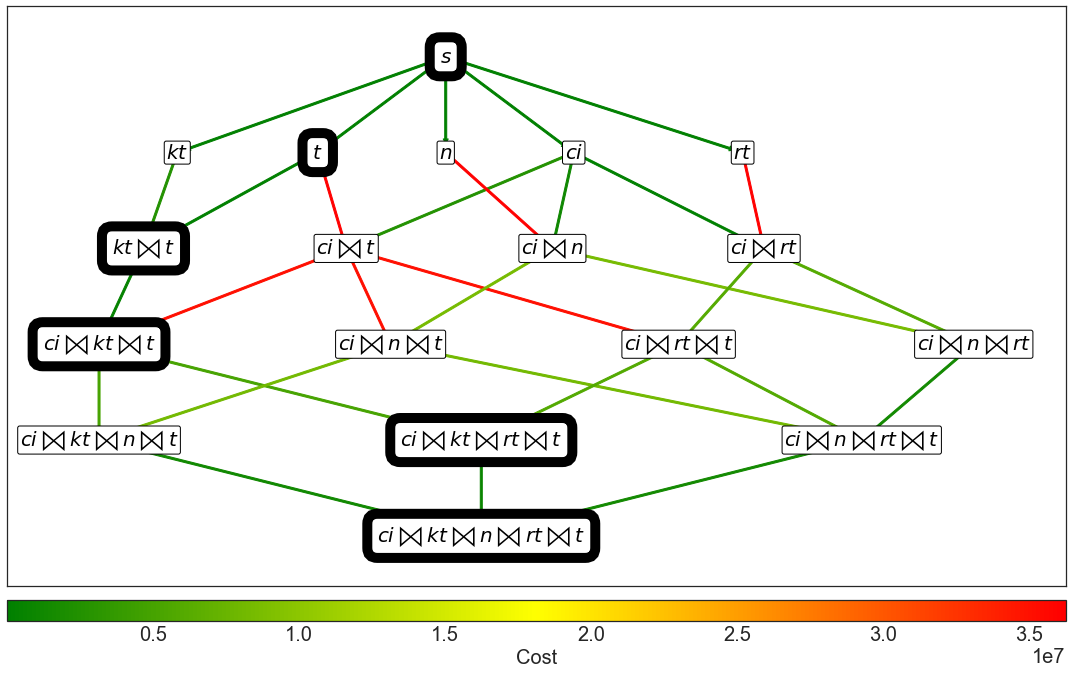

In [11]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
#from query_representation.utils import SOURCE_NODE
SOURCE_NODE = tuple(["s",])
draw_plan_graph(subsetg, ypg, "C", ax=ax, source_node=SOURCE_NODE,
               final_node=final_node, font_size=20, width=.0, edge_color=None, 
               bold_opt_path=True)

plt.show()

# Evaluation Functions

* Now, that we have explained what these evaluation functions are, here we just import their implementations to be used for evaluating the learned models.
* SimplePlanCost is an approximation to a DBMS based plan cost (for instance, PostgresPlanCost --- implemented in evaluation.eval_fns as well). There are two simplifying assumptions in SimplePlanCost:
    * Only considers left deep plans
    * Cost model is quite simple simple; it only really makes sense in case of index nested loop joins. In reality, indices may not exist, other join kinds may be better etc. Even so, it is fairly correlated with Postgres Plan Cost in our experiments.

In [12]:
from evaluation.eval_fns import QError, SimplePlanCost
EVAL_FNS = []
EVAL_FNS.append(QError())
EVAL_FNS.append(SimplePlanCost())

# Helper function for initializing featurizer

* Featurizer object contains information about the db, e.g., tables, joins, columns, how to featurize predicate filters etc.

In [13]:
def init_featurizer(featurization_type):
    # Load database specific data, e.g., information about columns, tables etc.
    dbdata_fn = os.path.join(TRAINDIR, "dbdata.json")
    featurizer = Featurizer(None, None, None, None, None)
    with open(dbdata_fn, "r") as f:
        dbdata = json.load(f)
    featurizer.update_using_saved_stats(dbdata)

    # ynormalization: takes log(y) for all target values, y.
    featurizer.setup(ynormalization="log",
            featurization_type=featurization_type)
    featurizer.update_ystats(trainqs)
    return featurizer

In [14]:
# going to start training the models
trainqs = load_qdata(train_qfns)

# Submission code

In [15]:
def save_submission(predictions, filename):
    "Take model output & save for cardinality estimation benchmark upload."""
    np.save(filename, np.array([value for item in predictions for key, value in sorted(item.items())]))

# RandomForest model

In [16]:
from cardinality_estimation.algs import RandomForest
featurizer = init_featurizer("combined")
rf = RandomForest(grid_search = False,
                n_estimators = 10,
                max_depth = 6)
rf.train(trainqs, valqs=None, testqs=None,
    featurizer=featurizer, result_dir=RESULTDIR)

Extracting features took:  8.928250789642334


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 10building tree 2 of 10building tree 3 of 10

building tree 4 of 10

building tree 5 of 10building tree 6 of 10
building tree 7 of 10

building tree 8 of 10building tree 9 of 10building tree 10 of 10




[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.8s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


In [25]:
# evaluate model
eval_alg(rf, EVAL_FNS, trainqs, "train")
eval_alg(rf, EVAL_FNS, val_qfns, "val")

preds = get_preds(rf, test_qfns)

Extracting features took:  8.651225090026855


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


train, RandomForest, #samples: 52158, QError: mean: 33.8, median: 3.537, 99p: 303.629
train, RandomForest, #samples: 119, SimplePlanCost: mean: 3593890.036, median: 1439083.683, 99p: 34651621.236
Extracting features took:  47.82698178291321


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


val, RandomForest, #samples: 271741, QError: mean: 331.142, median: 4.227, 99p: 2474.906
val, RandomForest, #samples: 621, SimplePlanCost: mean: 3246627.1, median: 878902.557, 99p: 33202786.373
Extracting features took:  105.07688021659851


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


# Save submission file

In [24]:
save_submission(preds, "mysubmisson.npy")

# XGBoost

In [100]:
from cardinality_estimation.algs import XGBoost
featurizer = init_featurizer("combined")
xgb = XGBoost(grid_search=False, tree_method="hist",
                       subsample=1.0, n_estimators = 100,
                       max_depth=10, lr = 0.01)
xgb.train(trainqs, valqs=None, testqs=None,
    featurizer=featurizer, result_dir=RESULTDIR)

Extracting features took:  22.899195909500122


In [ ]:
# evaluate model
eval_alg(xgb, EVAL_FNS, trainqs, "train")
eval_alg(xgb, EVAL_FNS, valqs, "val")


# TODO: test set prdictions; should submit these for the leaderboard?
#preds = xgb.test(testqs)

# Fully Connected Neural Network / Multilayer Perceptron

In [89]:
from cardinality_estimation.fcnn import FCNN
featurizer = init_featurizer("combined")
fcnn = FCNN(max_epochs = 10,
     lr=0.0001,
     mb_size = 512,
     weight_decay = 0.0,
     result_dir = "./results",
     num_hidden_layers=4,
     optimizer_name="adamw",
     clip_gradient=20.0,
     loss_func_name = "mse",
     hidden_layer_size = 256)

fcnn.train(trainqs, valqs=None, testqs=None,
    featurizer=featurizer, result_dir=RESULTDIR)

Extracting features took:  22.69448685646057
SimpleRegression(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=515, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)
training samples: 133784, feature length: 515, model size: 1.318916,
        hidden_layer_size: 256
Epoch 0 took 2.22, Avg Loss: 0.009701
Epoch 1 took 2.69, Avg Loss: 0.00216
Epoch 2 took 2.37, Avg Loss: 0.001335
Epoch 3 took 2.49, Avg Loss: 0.00103
Epoch 4 took 2.48, Avg Loss: 0.000851
Epoch 5 took 2.46, Avg Loss: 0.00075
Epoch 6 took 2.5, Avg Loss: 0.000655

In [90]:
# evaluate model
eval_alg(fcnn, EVAL_FNS, trainqs, "train")
eval_alg(fcnn, EVAL_FNS, valqs, "val")

# TODO: test set prdictions; should submit these for the leaderboard?
#preds = fcnn.test(testqs)

Experiment name will be:  FCNN1017090249
Extracting features took:  22.05372905731201
train, FCNN, #samples: 133784, QError: mean: 1.834, median: 1.347, 99p: 6.04
train, FCNN, #samples: 307, SimplePlanCost: mean: 2868145.107, median: 471279.311, 99p: 48213382.76


# Multi Set Convolutional Network

## Notes

* Introduced by Kipf et al. in this [paper](https://arxiv.org/abs/1809.00677). Architecture based on [Deep Sets](https://arxiv.org/abs/1703.06114).
* Does not reserve an exact mapping for features on a particular table / column. Treats table features, join features, and predicate features as set of vectors. Has practical benefits over the flat 1d featurization (see discussion in README). But requires each batch to have same shape; thus a lot of the smaller query features need to be padded with zeros, which makes the memory consumption become much larger (can probably improve this somehow).
* load_padded_mscn_feats = True (see MSCN initialization below), loads these padded sets in memory; takes more RAM, but is faster; load_padded_mscn_feats = False, pads the vectors as needed --- takes longer to train (TODO: current python implementation can be improved).

In [104]:
from cardinality_estimation.mscn import MSCN

featurizer = init_featurizer("set")

# load_padded_mscn_feats = True means all the fea
mscn = MSCN(max_epochs = 10,
     load_padded_mscn_feats = False,
     lr=0.0001,
     mb_size = 512,
     weight_decay = 0.0,
     result_dir = "./results",
     optimizer_name="adamw",
     clip_gradient=20.0,
     loss_func_name = "mse",
     hidden_layer_size = 256)

mscn.train(trainqs, valqs=None, testqs=None,
    featurizer=featurizer, result_dir=RESULTDIR)

Extracting features took:  27.066265106201172
SetConv(
  (sample_mlp1): Linear(in_features=15, out_features=256, bias=True)
  (sample_mlp2): Linear(in_features=256, out_features=256, bias=True)
  (predicate_mlp1): Linear(in_features=55, out_features=256, bias=True)
  (predicate_mlp2): Linear(in_features=256, out_features=256, bias=True)
  (join_mlp1): Linear(in_features=43, out_features=256, bias=True)
  (join_mlp2): Linear(in_features=256, out_features=256, bias=True)
  (out_mlp1): Linear(in_features=768, out_features=256, bias=True)
  (out_mlp2): Linear(in_features=256, out_features=1, bias=True)
)
training samples: 133784, model size: 1.696772,
        hidden_layer_size: 256
Epoch 0 took 90.57, Avg Loss: 0.012292
Epoch 1 took 95.94, Avg Loss: 0.005715
Epoch 2 took 97.58, Avg Loss: 0.0046
Epoch 3 took 93.91, Avg Loss: 0.004018
Epoch 4 took 93.38, Avg Loss: 0.003625
Epoch 5 took 96.69, Avg Loss: 0.003289
Epoch 6 took 91.85, Avg Loss: 0.003012
Epoch 7 took 94.12, Avg Loss: 0.002765
Epo

In [102]:
# evaluate model
eval_alg(mscn, EVAL_FNS, trainqs, "train")
eval_alg(mscn, EVAL_FNS, valqs, "val")

# TODO: test set prdictions; should submit these for the leaderboard?
#preds = mscn.test(testqs)

Experiment name will be:  MSCN132345184
Extracting features took:  104.61881613731384
train, MSCN, #samples: 133784, QError: mean: 37.971, median: 2.293, 99p: 45.606
train, MSCN, #samples: 307, SimplePlanCost: mean: 3125948.222, median: 505817.82, 99p: 37967613.474
